In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.pyplot import figure, show, contour, contourf, Circle, Rectangle
from matplotlib import ticker
import matplotlib.pyplot as plt
import prodimopy.read as pread
import prodimopy.plot as pplot
from scipy.interpolate import griddata
from scipy.integrate import odeint
from random import random, randint
import pickle
import os
from scipy.stats import skew
from scipy.optimize import curve_fit
        

In [2]:
%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Setting main directories

In [3]:
pathdict = {}

# Change this variable to the folder where your ProDiMo model output is located.
pathdict["disk"] = "./BackgroundModels/vFrag1/"

# Location and name of the input file.
pathdict["input"] = "./InputFiles/"

# Folder where the model data of monomer simulations are saved and where simulations are loaded from.
pathdict["simulation"] = "./Simulations/"

# Folder where the figure files are saved.
pathdict["figures"] = "./Figures/"

# Main project directory where the shampoo.py and this notebook are located.
pathdict["project"] = "./"

# Loading the background model

In [4]:
import shampoo

disk = shampoo.Disk(species=["H2O", "CO", "CO2", "CH4", "CH3OH", "NH3", "H2S", "SO2", "OCS"], folder=pathdict["disk"], modelName="ProDiMo.out", 
                         t_index="{:04d}".format(5))

['H2O', 'CO', 'CO2', 'CH4', 'CH3OH', 'NH3', 'H2S', 'SO2', 'OCS']
./BackgroundModels/vFrag1/
READ: Reading File:  ./BackgroundModels/vFrag1//ProDiMo_0005.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//Species.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//FlineEstimates_0005.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//Elements.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//dust_opac.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//dust_sigmaa.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//StarSpectrum.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//SED.out  ...
WARN: Could not open ./BackgroundModels/vFrag1//SEDana.out!
READ: Reading File:  ./BackgroundModels/vFrag1//image.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//Parameter.out  ...
INFO: Reading time:  2.53 s
 
READ: Reading File:  ./BackgroundModels/vFrag1//dust_opac.out  ...
READ: Reading File:  ./BackgroundModels/vFrag1//dust_sigmaa.out  ...
Finishe

# The plotting script

In [7]:
plt.rcParams['legend.title_fontsize'] = '14'
def calculateShades(mod):

    
    expArr = mod.monomer.sec_sol["exposed"] 
    
    if expArr[0]==1:
        startPos = [0]
    else:
        startPos = []
    stopPos = []
    
    for t in range(1,len(expArr)):
        if ((mod.monomer.sec_sol["exposed"])[t]==1)and ((mod.monomer.sec_sol["exposed"])[t-1]==0):
            startPos.append(mod.monomer.t_sol[t])
            
        elif ((mod.monomer.sec_sol["exposed"])[t]==0)and ((mod.monomer.sec_sol["exposed"])[t-1]==1):
            stopPos.append(mod.monomer.t_sol[t])
    
    if (mod.monomer.sec_sol["exposed"])[-1]==1:
        stopPos.append(mod.monomer.t_sol[-1])

    xwidths = np.array(stopPos)-np.array(startPos)
    
    return startPos, stopPos, xwidths
        
def addShapes(frame, startPos, stopPos, xwidths):
    
    for n in range(len(xwidths)):
        frame.add_patch(Rectangle((startPos[n], -5e5), xwidths[n], 1e10, facecolor=(0,.6,0), alpha=.25))
        

def testModel(disk, pathdict, tMin, tMax, generate=False, name="DemoModel", inputName=None):
    """
    Auxiliary function meant for testing the model.
    
    disk: Instance of Disk which serves as the background model.
    tMin: lower xlim in kyr
    tMax: upper xlim in kyr
    generate: (Re)Do the integration (True) or look for file of name "Model" (False)
    name: Model save file name.
    """
    
    #---------------------------------------------------------------------------------------
    
    if inputName==None:
        inputName = name
    
    if generate:
        mod = shampoo.Model(disk=disk, parameter_folder=pathdict["input"]+inputName)
        mod.integrateMonomer()
        pickle.dump(mod, open(pathdict["simulation"]+name+".pickle", "wb"))
    else:
        try:
            mod = pickle.load(open(pathdict["simulation"]+name+".pickle", "rb"))
            print("Loaded model with seed: ", mod.seedStart)
        except:
            mod = None
            print("Did not find file: ",pathdict["simulation"]+name+".pickle")
       
 
    frameTotList = []
    
    if mod.trackice:
        startPos, stopPos, xwidths = calculateShades(mod)
    #---------------------------------------------------------------------------------------
    
    if mod.migration:
        figDyn = figure(figsize=(12,7))   # Figure relevant for the dynamics. Tracks the particle position.
        frameDynList = [None]*4
        
        for f in range(4):
            frameDynList[f] = figDyn.add_subplot(2,2,f+1)
            if mod.trackice:
                addShapes(frameDynList[f], startPos, stopPos, xwidths)
        

        frameDynList[0].plot(mod.monomer.t_sol, mod.monomer.z_sol/mod.monomer.r_sol, zorder=1, 
                             linewidth=2)
        frameDynList[1].plot(mod.monomer.t_sol, mod.monomer.r_sol, zorder=1, 
                             linewidth=2)
        frameDynList[2].plot(mod.monomer.t_sol, mod.monomer.sec_sol["Td"], zorder=1, 
                             linewidth=2)
        frameDynList[3].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol["chiRT"], zorder=1, 
                                 linewidth=2)
        
        frameDynList[0].set_ylabel("z/r", fontsize=16)
        frameDynList[1].set_ylabel("r (AU)", fontsize=16)
        frameDynList[2].set_ylabel("Monomer temperature (K)", fontsize=16)
        frameDynList[3].set_ylabel(r"UV radiation field ($F_{Draine}$)", fontsize=16)
            
        maxZ = 1.2*np.max(mod.monomer.z_sol/mod.monomer.r_sol)
            
        minR = np.max([0,0.8*np.min(mod.monomer.r_sol)])
        maxR = 1.2*np.max(mod.monomer.r_sol)
          
        minT = 0.8*np.min(mod.monomer.sec_sol["Td"])
        maxT = np.min([250,1.2*np.max(mod.monomer.sec_sol["Td"])])
        
        minX = 1e-10#0.1*np.min(stackX)
        maxX = max([10*np.max(mod.monomer.sec_sol["chiRT"]), 10])
        
        frameDynList[0].plot([tMin,tMax],[0,0], linewidth=3, color=(0,0,0), linestyle="--")
        frameDynList[3].plot([tMin,tMax],[1,1], linewidth=3, color=(0,0,0), linestyle="--")
        
        
        
        frameDynList[0].set_ylim(-maxZ,maxZ)
        frameDynList[1].set_ylim(minR,maxR)
        frameDynList[2].set_ylim(0,maxT)
        frameDynList[3].set_ylim(minX, maxX)
        
        figDyn.tight_layout(pad=3)
        frameTotList.append(frameDynList)
    
    #---------------------------------------------------------------------------------------
    

    #---------------------------------------------------------------------------------------
    
    if mod.collisions:
        figCoa = figure(figsize=(12,4))     # Figure which tracks home aggregate size and latest collisional interaction.
        
        frameCoa = figCoa.add_subplot(1,1,1)
        #frameRel = figCoa.add_subplot(2,1,2)
        #frameCoaList = [frameCoa, frameRel]
        frameCoaList = [frameCoa]
        
        # Panel 1
        #tAuxsol = np.copy(mod.monomer.t_sol)
        #sAuxsol = np.copy(mod.monomer.sAgg_sol)
        #L = len(mod.monomer.t_sol)
        #l = 1
        
        
        #inds = np.where((sAuxsol[0:-1]-sAuxsol[1::])!=0, np.indices, 0)
        #print(inds)
        
        frameCoaList[0].semilogy(mod.monomer.t_sol, mod.monomer.sAgg_sol, zorder=-1, color=(.5,.5,.5), linewidth=2)
        interactionList = ["Nothing", "Coagulation", "Fragmentation", "Erosion", "Ejection", "Impact"]
            
        for t in range(1,6):
            cond = np.argwhere(mod.monomer.sec_sol["interaction"]==t)
            tArr = mod.monomer.t_sol[cond]
            data = mod.monomer.sAgg_sol[cond]
            frameCoaList[0].scatter(tArr, data, label=interactionList[t])
    
        frameCoaList[0].set_ylabel("Home aggregate size", fontsize=16)
        frameCoaList[0].legend(title="Collision event", loc="lower center", ncol=5, fontsize=12, bbox_to_anchor=(0., -.45, 1., 0.5))

        frameTotList.append(frameCoaList)
   
    #---------------------------------------------------------------------------------------

    if mod.trackice:
        figIce1 = figure(figsize=(18,4))
        figIce2 = figure(figsize=(12,4))
        # Figure which contains 1. monomer depth, 2. total ice budget, 3. ice abundance, 
                                            # 4. element abundance, 5. element ratios
        
        frameIceList = [None]*5
        
        for f in range(5):
            if f<3:
                #if f==0: ##################### Temporary change for EPSC abstract
                frameIceList[f] = figIce1.add_subplot(1,3,f+1) 
#                 elif f==1:
#                     frameIceList[f] = figIce1.add_subplot(1,3,1)
#                 else:
#                     frameIceList[f] = figIce1.add_subplot(1,3,f+1)
            else:
                frameIceList[f] = figIce2.add_subplot(1,2,f-2)
            

            addShapes(frameIceList[f], startPos, stopPos, xwidths)
         
            
        
        # Panel 1: Monomer depth in home aggregate.
        colorExposed = (0,.6,0)
        colorIsolate = (1,0,0)
        exposed = np.ma.masked_where(mod.monomer.sec_sol["exposed"]==0, mod.monomer.zMon_sol)
        isolate = np.ma.masked_where(mod.monomer.sec_sol["exposed"]==1, mod.monomer.zMon_sol)
            
        frameIceList[0].semilogy(mod.monomer.t_sol, exposed, zorder=1, linewidth=2, color=colorExposed)
        frameIceList[0].semilogy(mod.monomer.t_sol, isolate, zorder=1, linewidth=2, color=colorIsolate)
            
        for t in range((len(mod.monomer.t_sol)-1)):
               
            if (mod.monomer.sec_sol["exposed"][t+1]!=mod.monomer.sec_sol["exposed"][t]):
                xDat = [mod.monomer.t_sol[t], mod.monomer.t_sol[t+1]]
                yDat = [mod.monomer.zMon_sol[t], mod.monomer.zMon_sol[t+1]]
                    
                if mod.monomer.sec_sol["exposed"][t]==0:
                    frameIceList[0].semilogy(xDat, yDat, zorder=1, linewidth=2, color=colorIsolate)
                else:
                    frameIceList[0].semilogy(xDat, yDat, zorder=1, linewidth=2, color=colorExposed)
            
            
        
        #frameIceList[0].semilogy(mod.monomer.t_sol, mod.monomer.zMon_sol, zorder=1, linewidth=2)
        frameIceList[0].plot([mod.monomer.t_sol[0], mod.monomer.t_sol[-1]], [mod.monomer.prop["zCrit"],mod.monomer.prop["zCrit"]], color=(0,0,0), linewidth=2, linestyle="--")
        frameIceList[0].set_ylim(1e-8, 1e-2)
        frameIceList[0].annotate(r"$z_m=z_{crit}$", (82, mod.monomer.prop["zCrit"]*0.7), fontsize=12)
        
        
        
        # Panel 2: Monomer total ice mass.

        frameIceList[1].plot(mod.monomer.t_sol, mod.monomer.iceTot_sol/mod.monomer.prop["mMon"], zorder=1, linewidth=2)
        frameIceList[1].set_ylim(0,1.2*np.max(mod.monomer.iceTot_sol/mod.monomer.prop["mMon"]))
        
        
        
        
        
        
        for item in disk.iceList:
            relVal = (mod.monomer.ice_sol[item])/mod.monomer.iceTot_sol
            #print(relVal)
            relVal[mod.monomer.iceTot_sol<1e-99] = 0
            #if np.max(relVal)>0.05:
            frameIceList[2].semilogy(mod.monomer.t_sol, relVal, label=item, linewidth=2)
            #else:
            #    frameIceList[2].semilogy(mod.monomer.t_sol, relVal, linewidth=2, color=(.5,.5,.5))
            frameIceList[2].set_ylim(1e-14,2e0)
        # Panel 4: Abundance of elements in the ice mantle.
        E = 5
        colorList = [(0,0,1),(0,0,0),(1,0,1),(1,0,0),(1,.8,.1)]
        elementList = ["H", "C", "N", "O", "S"]
        for e in range(E):
            relVal = mod.monomer.ele_sol[:,e]/mod.monomer.iceTot_sol
            relVal[mod.monomer.iceTot_sol<1e-99] = 0
            frameIceList[3].semilogy(mod.monomer.t_sol, relVal, color=colorList[e], linewidth=2, label=elementList[e])
            
        frameIceList[3].set_ylim(1e-9, 1e0)
        # Panel 5: Element ratios.
        for item in mod.monomer.sec_sol.keys():
            if item[0:3]=="rat":
                frameIceList[4].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol[item], linewidth=2, label=item[-3::])
        frameIceList[4].set_ylim(1e-9, 1e2)
    

    
        frameIceList[0].set_ylabel(r"Monomer depth $z_m$ (m)", fontsize=16)
        frameIceList[1].set_ylabel(r"Total ice mass ($m_{ice}/m_m$)", fontsize=16)
        frameIceList[2].set_ylabel(r"Mass fraction", fontsize=16)
        frameIceList[2].legend(title="Molecule", loc="lower left", ncol=3, fontsize=14)
        frameIceList[3].set_ylabel(r"Mass fraction", fontsize=16)
        frameIceList[3].legend(title="Element", fontsize=14, ncol=3)
        frameIceList[4].set_ylabel(r"Element ratio", fontsize=16)
        frameIceList[4].legend(title="Ratio", fontsize=14, ncol=3)
        
        frameIceList[0].invert_yaxis()
    
        figIce1.tight_layout(pad=2)
        figIce2.tight_layout(pad=2)
        frameTotList.append(frameIceList)
    #---------------------------------------------------------------------------------------
    
    figNum = figure(figsize=(6,4))               # Figure which tracks the timestep size.
    frameNum = figNum.add_subplot(1,1,1)
    frameNumList = [frameNum]
        
    frameNumList[0].semilogy(mod.monomer.t_sol, mod.monomer.sec_sol["delta_t"]/mod.sTOyr, zorder=1, linewidth=2)
    
    frameNumList[0].set_ylabel("Timestep size (yr)", fontsize=18)
    
    figNum.tight_layout(pad=2)
    frameTotList.append(frameNumList)
    
    for frames in frameTotList:
        for f in frames:
            f.set_xlim(tMin, tMax)
            f.set_xlabel("Time (kyr)", fontsize=18)
            f.grid()
            f.tick_params(labelsize=14)
        
        
    for fmt in ["pdf"]:
        
        if mod.migration:
            figDyn.savefig(pathdict["figures"]+name+"Dynamics."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
        
        if mod.trackice:
            figIce1.tight_layout(pad=1)
            figIce1.savefig(pathdict["figures"]+name+"IceEvolution1."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
            figIce2.savefig(pathdict["figures"]+name+"IceEvolution2."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
        
        if mod.collisions:
            figCoa.savefig(pathdict["figures"]+name+"Collisions."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
            
        figNum.savefig(pathdict["figures"]+name+"Numerics."+fmt, format=fmt, bbox_inches = 'tight', pad_inches = 0.1)
        
    print("Done!")

# Example output

 ------------------------------------------------------------------------ 
|                                                                        |
|                           Welcome to SHAMPOO                           |
|                                                                        |
|                      StocHAstic Monomer PrOcessOr                      |
|                                                                        |
|          Dynamical, collisional and ice processing since 2022          |
|                                                                        |
 ------------------------------------------------------------------------ 
Attempting to load parameters from folder:  ./InputFiles/DemoModel
Attempt succesful!
Initializing model
Finished model initialization in 0.00 CPU s
 
--------------------------------------------------
 
Initializing monomer... 
 
--------------------------------------------------
 
Set initial monomer position to: r0 = 60.

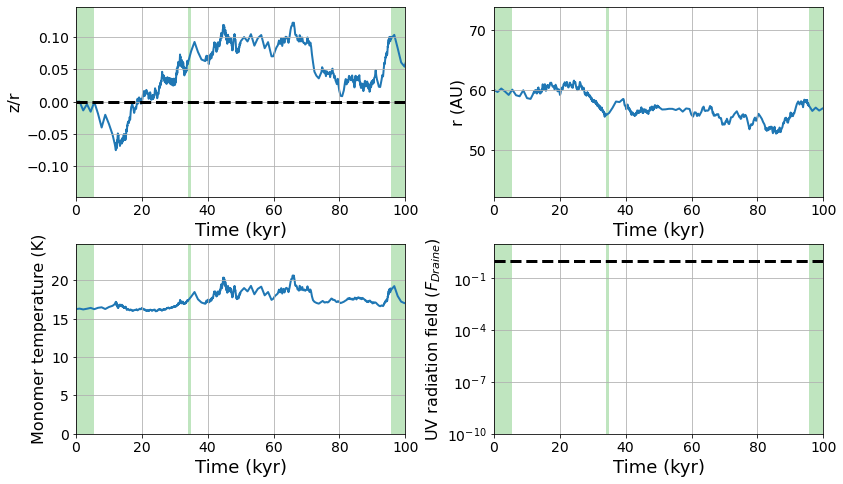

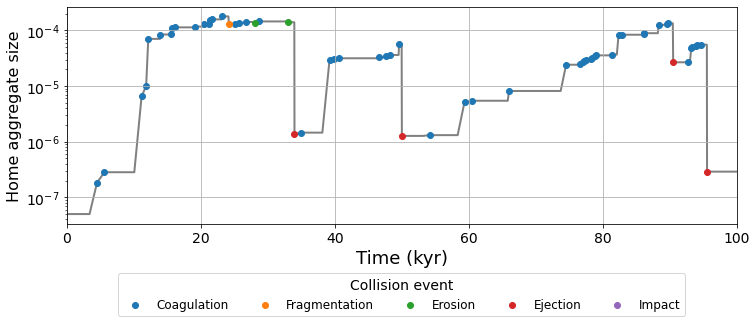

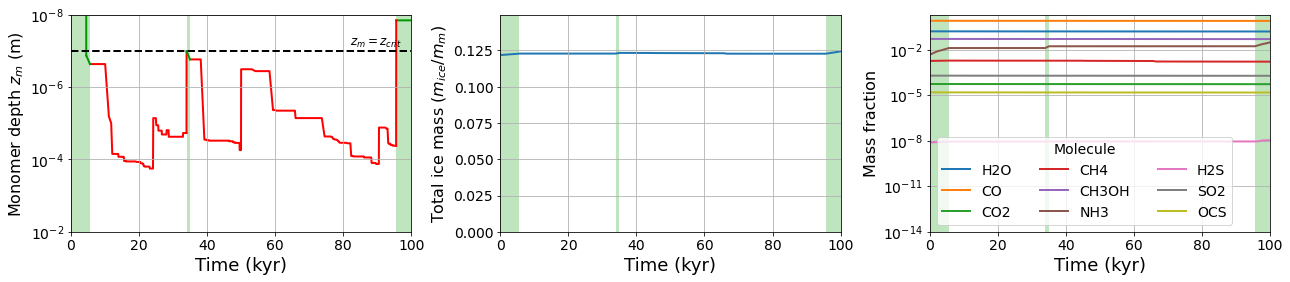

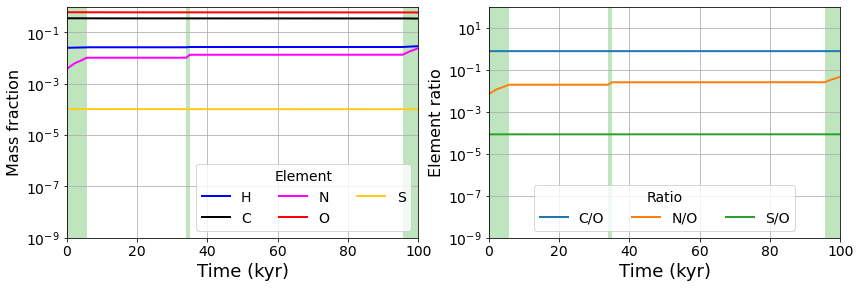

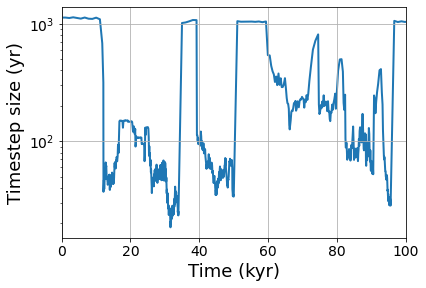

In [8]:
testModel(disk, pathdict, 0, 100, generate=True, name="DemoModel", inputName=None)

# Loading model data yourself

In [12]:
def loadBareModel(name):
    
    mod = pickle.load(open(pathdict["simulation"]+name+".pickle", "rb"))
    
    # See the code block above for insight on access to individual model variables.
    
loadBareModel(name="DemoModel")